In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
%matplotlib inline
import seaborn as sns; sns.set_theme(color_codes=True)
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
import math    
import folium
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist
import sys
from haversine import haversine

In [2]:
labels = pd.read_csv('datasets/mikey-devon-labels_validation.csv',delimiter=";")

In [3]:
#create labels geo dataframe
points = labels.apply(lambda row: Point(row.lng, row.lat), axis=1)
labels_geo = gpd.GeoDataFrame(labels, geometry=points)
labels_geo.crs = {'init': 'epsg:4326'}
labels_geo

,username,label_id,street_edge_id,neighborhood,label_type,lat,lng,gsv_panorama_id,time_created,correct,severity,temporary,tag_list,description,geometry
0,Devon Snyder,1,480,University District,Occlusion,47.661045,-122.321037,-L8Sgb0ozIqqanCBfAZjYQ,2022-05-10 14:00:02.905-07,NaN,NaN,f,NaN,NaN,POINT (-122.32104 47.66105)
1,Devon Snyder,3,480,University District,Obstacle,47.661041,-122.320709,-L8Sgb0ozIqqanCBfAZjYQ,2022-05-10 14:00:36.787-07,t,3.0,f,pole,NaN,POINT (-122.32071 47.66104)
2,Devon Snyder,4,480,University District,Obstacle,47.661026,-122.320702,-L8Sgb0ozIqqanCBfAZjYQ,2022-05-10 14:00:52.367-07,t,2.0,f,pole,NaN,POINT (-122.32070 47.66103)
3,Devon Snyder,5,480,University District,SurfaceProblem,47.661060,-122.320709,OH4yKYW98UY1aMK_b68Etw,2022-05-10 14:01:21.608-07,t,2.0,f,bumpy,NaN,POINT (-122.32071 47.66106)
4,Devon Snyder,6,480,University District,Occlusion,47.660900,-122.321007,OH4yKYW98UY1aMK_b68Etw,2022-05-10 14:01:52.042-07,NaN,NaN,f,NaN,NaN,POINT (-122.32101 47.66090)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2371,mikey,2493,810,Windermere,SurfaceProblem,47.672043,-122.267929,Z6BJD4bSdDiMxwMdls5oNw,2022-07-06 14:12:40.653-07,NaN,1.0,f,uneven/slanted,NaN,POINT (-122.26793 47.67204)
2372,mikey,2494,716,Windermere,Obstacle,47.671928,-122.268097,sOyfUL3XT8ETE-9XfeaXvQ,2022-07-06 14:14:34.691-07,NaN,1.0,f,vegetation,NaN,POINT (-122.26810 47.67193)
2373,mikey,2495,715,Windermere,NoSidewalk,47.672016,-122.268433,xbqjQfJSHA1O90JnBHQJGw,2022-07-06 14:14:48.626-07,NaN,3.0,f,street has a sidewalk,NaN,POINT (-122.26843 47.67202)
2374,mikey,2496,716,Windermere,SurfaceProblem,47.671883,-122.268181,xbqjQfJSHA1O90JnBHQJGw,2022-07-06 14:14:55.957-07,NaN,1.0,f,cracks,NaN,POINT (-122.26818 47.67188)


In [4]:
# Seperate Seattle and Chicago data
chicago = labels_geo.loc[labels_geo['lng'] > -105]
seattle = labels_geo.loc[labels_geo['lng'] < -105]

In [5]:
#Separate a testing dataset
street_s = seattle[(seattle['street_edge_id']==479)]
street_c = chicago[(chicago['street_edge_id']==381)]

# Clustering Functions

In [6]:
def custom_dist(u, v):
    if u[2] == v[2]:
        return sys.float_info.max
    else:
        return haversine([u[0], u[1]], [v[0], v[1]])

In [7]:
thresholds = {'CurbRamp': 0.0075,
                      'NoCurbRamp': 0.0075,
                      'SurfaceProblem': 0.01,
                      'Obstacle': 0.01,
                      'NoSidewalk': 0.01,
                      'Crosswalk': 0.01,
                      'Signal': 0.01,
                      'Occlusion': 0.01,
                      'Other': 0.01,
                      'Problem': 0.01}

In [8]:
def cluster(labels, label_type, thresholds):

    # Makes a normal dist matrix for a single user, but uses special dist function for multi-user clustering that
    # prevents the same user's attributes from being clustered together.
    dist_matrix = pdist(np.array(labels[['lat', 'lng', 'username']].values), custom_dist)
    link = linkage(dist_matrix, method='complete')
    curr_type = labels['label_type'].values

    # Copies the labels dataframe and adds a column to it for the cluster id each label is in.
    labelsCopy = labels.copy()
    labelsCopy.loc[:,'cluster'] = fcluster(link, t=thresholds[label_type], criterion='distance')

    # Cuts tree so that only labels less than clust_threth kilometers apart are clustered.
    clusters = labelsCopy.groupby('cluster')

    # Computes the center of each cluster and assigns temporariness and severity.
    cluster_list = [] # list of tuples (label_type, cluster_num, lat, lng, severity, temporary).
    for clust_num, clust in clusters:
        #ave_pos = np.mean(clust['coords'].tolist(), axis=0) # use ave pos of clusters.
        #ave_sev = None if pd.isnull(clust['severity']).all() else int(round(np.median(clust['severity'][~np.isnan(clust['severity'])])))
        #ave_temp = None if pd.isnull(clust['temporary']).all() else bool(round(np.mean(clust['temporary'])))

        cluster_list.append((curr_type, clust_num))

    cluster_df = pd.DataFrame(cluster_list, columns=['label_type', 'cluster'])

    return (cluster_df, labelsCopy)

In [9]:
# Pick which label types should be included in clustering, and which should be included in the "Problem" type.
label_types = ['CurbRamp', 'NoSidewalk', 'Problem', 'Occlusion', 'SurfaceProblem', 'Obstacle', 'Other', 'NoCurbRamp', 'Crosswalk', 'Signal']
problem_types = ['SurfaceProblem', 'Obstacle']

# These are the columns required in the POST requests for the labels and clusters, respectively.
label_cols = ['label_id', 'label_type', 'cluster']
cluster_cols = ['label_type', 'cluster', 'lat', 'lng', 'severity', 'temporary']

In [10]:
def cluster_label_type_at_index(label_data,i):
        clusters_for_type_i = pd.DataFrame(columns=cluster_cols)
        labels_for_type_i = pd.DataFrame(columns=label_cols)

        label_type = label_types[i]
        if label_type == 'Problem':
            type_data = label_data[label_data.label_type.isin(problem_types)]
        else:
            type_data = label_data[label_data.label_type == label_type]

        # If there are >1 labels, we can do clustering. Otherwise just copy the 1 (or 0) labels.
        if type_data.shape[0] > 1:
            (clusters_for_type_i, labels_for_type_i) = cluster(type_data, label_type, thresholds)
        elif type_data.shape[0] == 1:
            labels_for_type_i = type_data.copy()
            labels_for_type_i.loc[:,'cluster'] = 1 # Gives the single cluster a cluster_id of 1.
            labels_for_type_i.loc[:,'label_type'] = label_type # Gives Problem type if needed.
            clusters_for_type_i = labels_for_type_i.filter(items=cluster_cols)

        return (label_type, clusters_for_type_i, labels_for_type_i)

In [224]:
def count_same_severity_clusters(label_data,i):
    df = cluster_label_type_at_index(label_data,i)[2]
    df["clustered"] = df.duplicated(subset="cluster", keep=False)
    df1 = df[df['clustered'] == True]
    a = df1['cluster'].unique().tolist()
    a.sort()
    counter = 0 
    for i in a: 
        b = df1.loc[df1['cluster'] == i]
        if  b['severity'].tolist()[0] == b['severity'].tolist()[1]:
            counter = counter + 1
    return counter, df1['cluster'].nunique(), round(counter/df1['cluster'].nunique(),2)

In [222]:
def count_same_severity_clusters_3(label_data,i):
    df = cluster_label_type_at_index(label_data,i)[2]
    df["clustered"] = df.duplicated(subset="cluster", keep=False)
    df1 = df[df['clustered'] == True]
    df1['severity'] = df1['severity'].map({1.0: 1.0, 2.0: 1.0,3.0: 2.0, 4.0:3.0, 5.0:3.0})
    a = df1['cluster'].unique().tolist()
    a.sort()
    counter = 0 
    for i in a: 
        b = df1.loc[df1['cluster'] == i]
        if  b['severity'].tolist()[0] == b['severity'].tolist()[1]:
            counter = counter + 1
    return counter, df1['cluster'].nunique(), round(counter/df1['cluster'].nunique(),2)

In [298]:
count_same_severity_clusters_3(chicago,2)

(40, 57, 0.7)

In [292]:
count_same_severity_clusters(seattle,2)

(114, 215, 0.53)

In [353]:
def pair_ttest(label_data,i):
    df = cluster_label_type_at_index(label_data,i)[2]
    df["clustered"] = df.duplicated(subset="cluster", keep=False)
    df1 = df[df['clustered'] == True]
    df2 = df1[['username','severity','cluster']]
    d = df2.loc[df2['username']!='mikey']
    m = df2.loc[df2['username'] =='mikey']
    m = m.rename(columns={"severity": "mikey"})
    d = d.rename(columns={"severity": "devon"})
    m = m.drop(columns=['username'])
    d = d.drop(columns=['username'])
    df3 = d.merge(m, how='inner', on='cluster').set_index('cluster')
    return stats.ttest_rel(df3.dropna()['mikey'], df3.dropna()['devon'])

In [358]:
def pair_ttest_3(label_data,i):
    df = cluster_label_type_at_index(label_data,i)[2]
    df["clustered"] = df.duplicated(subset="cluster", keep=False)
    df1 = df[df['clustered'] == True]
    df2 = df1[['username','severity','cluster']]
    df2['severity'] = df2['severity'].map({1.0: 1.0, 2.0: 1.0,3.0: 2.0, 4.0:3.0, 5.0:3.0})
    d = df2.loc[df2['username']!='mikey']
    m = df2.loc[df2['username'] =='mikey']
    m = m.rename(columns={"severity": "mikey"})
    d = d.rename(columns={"severity": "devon"})
    m = m.drop(columns=['username'])
    d = d.drop(columns=['username'])
    df3 = d.merge(m, how='inner', on='cluster').set_index('cluster')
    return stats.ttest_rel(df3.dropna()['mikey'], df3.dropna()['devon'])

In [359]:
pair_ttest_3(seattle,0)

Ttest_relResult(statistic=-6.247192691138228, pvalue=2.503068871955992e-08)

In [371]:
result = pd.DataFrame(columns=['label type','severity levels','t-score','p-value'])

In [372]:
for i in [seattle, chicago]:
    for j in [0,2]: 
        result = result.append({'label type': label_types[j],'severity levels': 5, 't-score': round(pair_ttest(i,j)[0],3) ,'p-value':round(pair_ttest(i,j)[1],3)},ignore_index=True)

In [373]:
for i in [seattle, chicago]:
    for j in [0,2]: 
        result = result.append({'label type': label_types[j],'severity levels': 3, 't-score': round(pair_ttest_3(i,j)[0],3),'p-value':round(pair_ttest_3(i,j)[1],3)},ignore_index=True)

In [374]:
cities =['Seattle','Seattle','Chicago','Chicago','Seattle','Seattle','Chicago','Chicago']
result.insert(loc=0, column='city', value=cities)

In [375]:
result

,city,label type,severity levels,t-score,p-value
0,Seattle,CurbRamp,5,-9.926,0.000
1,Seattle,Problem,5,1.519,0.130
2,Chicago,CurbRamp,5,-20.015,0.000
3,Chicago,Problem,5,-0.772,0.443
4,Seattle,CurbRamp,3,-6.247,0.000
5,Seattle,Problem,3,1.763,0.079
6,Chicago,CurbRamp,3,-6.964,0.000
7,Chicago,Problem,3,-0.782,0.438


# Visualization Functions

In [11]:
label_colors ={'Crosswalk':'#FABF1C',
               'CurbRamp':'#90C31F',
               'NoCurbRamp':'#E679B6',
               'NoSidewalk':'#BE87D8',
               'Obstacle' :'#78B0EA',
               'Occlusion':'#B3B3B3',
               'Other':'#B3B3B3',
               'Signal':'#63C0AB',
               'SurfaceProblem':'#F68D3E'}

In [12]:
def get_label_colors(geof):
    label_list = geof['label_type'].unique().tolist()
    label_list.sort()
    j = []
    for i in label_list:
        j.append(label_colors[i])
    return j

In [13]:
def visualize_validation(label_data,i):
    df = cluster_label_type_at_index(label_data,i)[2]
    df["clustered"] = df.duplicated(subset="cluster", keep=False)
    df1 = df[df['clustered'] == True]
    df2 = df[df['clustered'] != True]
    m = df2.explore(
        tiles="CartoDb DarkMatter",
        marker_type="circle",
        tooltip=["label_type", 'username','cluster','severity'],
        color = "#FFFFFF",
        marker_kwds={"radius":1.5, "fill":False},
        style_kwds={"stroke":True,"fillOpacity":1,"weight": 2}
    )
    
    
    return df1.explore(m=m,
                       tiles="CartoDb DarkMatter",
                       marker_type="circle",
                       tooltip=["label_type", 'username','cluster','severity'],
                       cmap=get_label_colors(df1),
                       column="label_type",
                       marker_kwds={"radius":1.5, "fill":True},
                       style_kwds={"stroke":True,"fillOpacity":0.6,"weight": 2},
                      )

In [14]:
def t_test (label_data,i):
    df = cluster_label_type_at_index(label_data,i)[2]
    df["clustered"] = df.duplicated(subset="cluster", keep=False)
    df1 = df[df['clustered'] == True]
    df2 = df1[['username','severity']]
    df2['severity'] = df2['severity'].map({1.0: 1.0, 2.0: 1.0,3.0: 2.0, 4.0:3.0, 5.0:3.0})
    m = df2.loc[df2["username"]=="mikey"]
    d = df2.loc[df2["username"]!="mikey"]    
    m_array = m["severity"].to_numpy(dtype="int64")
    d_array = d["severity"].to_numpy(dtype="int64")
    if np.var(m_array)/np.var(d_array) <4:
        t = stats.ttest_ind(a=m_array, b=d_array, equal_var=True)
    else:
        t = stats.ttest_ind(a=m_array, b=d_array, equal_var=False)
    
    return t  

In [73]:
def t_test_5 (label_data,i):
    df = cluster_label_type_at_index(label_data,i)[2]
    df["clustered"] = df.duplicated(subset="cluster", keep=False)
    df1 = df[df['clustered'] == True]
    df2 = df1[['username','severity']]
    m = df2.loc[df2["username"]=="mikey"]
    d = df2.loc[df2["username"]!="mikey"]    
    m_array = m["severity"].to_numpy(dtype="int64")
    d_array = d["severity"].to_numpy(dtype="int64")
    if np.var(m_array)/np.var(d_array) <4:
        t = stats.ttest_ind(a=m_array, b=d_array, equal_var=True)
    else:
        t = stats.ttest_ind(a=m_array, b=d_array, equal_var=False)    
    return t  

In [57]:
def plot_severity (label_data,i):
    df = cluster_label_type_at_index(label_data,i)[2]
    df["clustered"] = df.duplicated(subset="cluster", keep=False)
    df1 = df[df['clustered'] == True]
    df2 = df1[['username','severity']]
    df2['severity'] = df2['severity'].map({1.0: 1.0, 2.0: 1.0,3.0: 2.0, 4.0:3.0, 5.0:3.0})  
    plt.figure(figsize=(9,6))
    ax=sns.countplot(x="severity", data=df2, hue ="username",palette=flatui)
    for container in ax.containers:
        ax.bar_label(container)
    plt.xlabel(label_types[i])

In [287]:
def plot_agreement_severity (label_data,i):
    df = cluster_label_type_at_index(label_data,i)[2]
    df["clustered"] = df.duplicated(subset="cluster", keep=False)
    df1 = df[df['clustered'] == True]
    df2 = df1.copy()
    df2['severity'] = df1['severity'].map({1.0: 1.0, 2.0: 1.0,3.0: 2.0, 4.0:3.0, 5.0:3.0})  
    fig, ax =plt.subplots(2,1)
    fig.set_size_inches(30, 9)
    sns.barplot(x="cluster",y='severity', data=df1, hue ="username", palette=flatui,ax=ax[0])
    sns.barplot(x="cluster",y='severity', data=df2, hue ="username",palette=flatui,ax=ax[1])
    return fig.show()

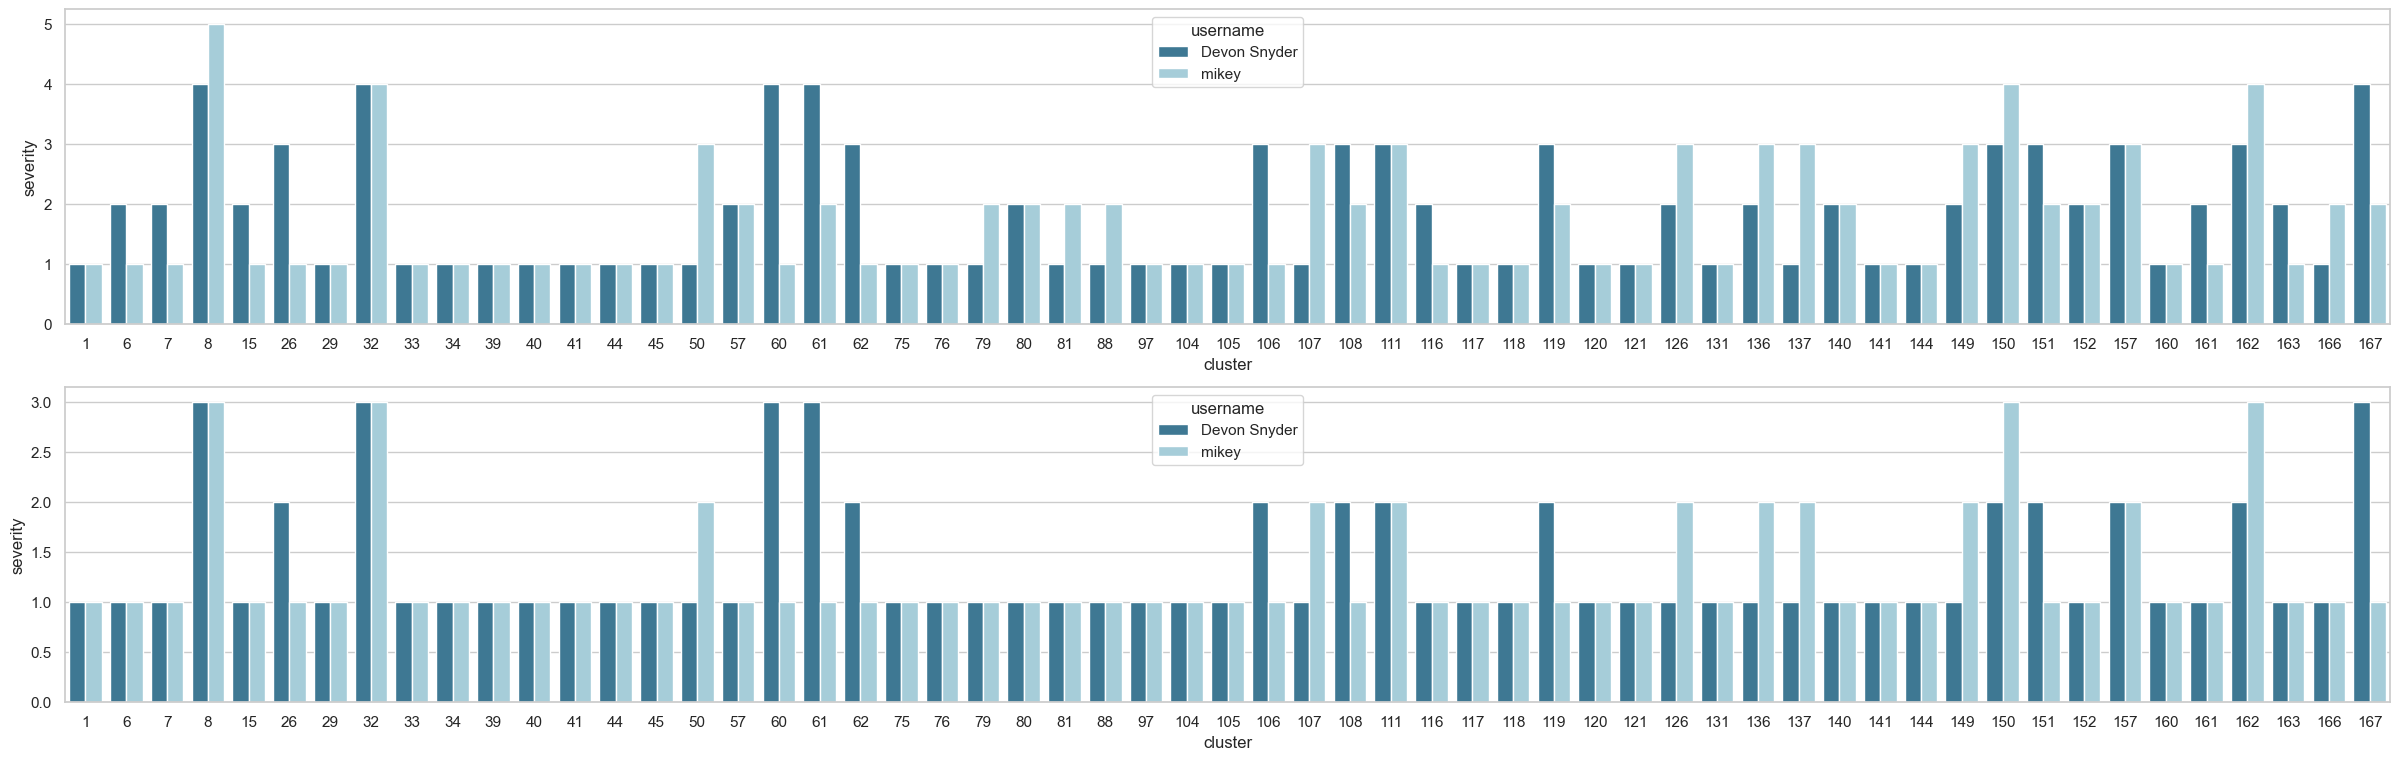

In [296]:
plot_agreement_severity (chicago,2)

In [55]:
def plot_severity_5 (label_data,i):
    df = cluster_label_type_at_index(label_data,i)[2]
    df["clustered"] = df.duplicated(subset="cluster", keep=False)
    df1 = df[df['clustered'] == True]
    df2 = df1[['username','severity']]
    plt.figure(figsize=(9,6))
    ax=sns.countplot(x="severity", data=df2, hue ="username",palette=flatui)
    for container in ax.containers:
        ax.bar_label(container)
    plt.xlabel(label_types[i])

In [44]:
flatui = ["#307DA1", "#9DD2E2", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
#sns.palplot(sns.color_palette(flatui))

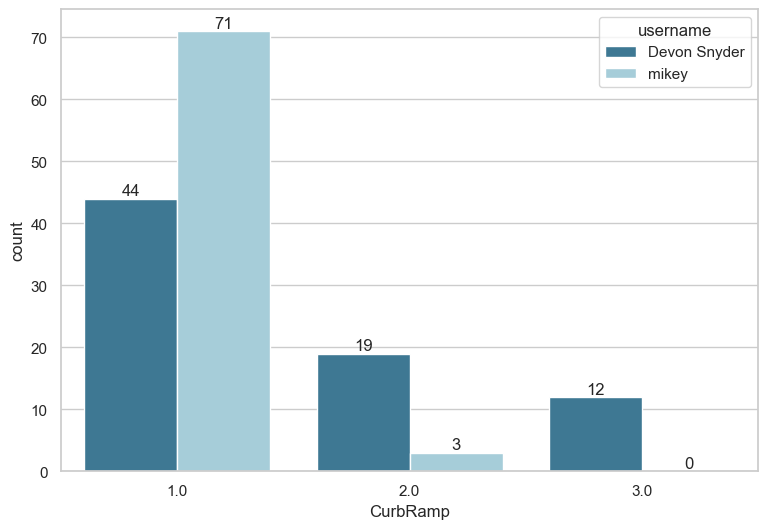

In [180]:
sns.set_theme(style="whitegrid")
plot_severity(seattle,0)

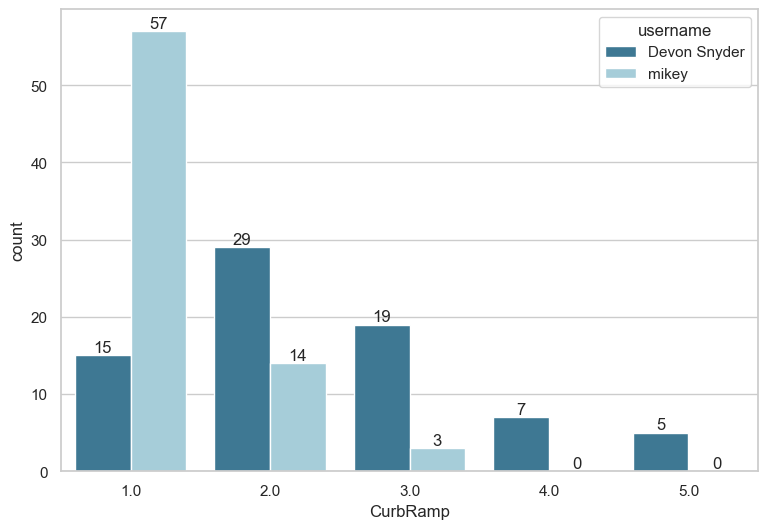

In [179]:
plot_severity_5(seattle,0)

In [78]:
t_test(chicago,2)

Ttest_indResult(statistic=-0.6082287370157644, pvalue=0.5442672590901898)

In [79]:
t_test_5(chicago,2)

Ttest_indResult(statistic=-0.5554637206007073, pvalue=0.57968533853198)

In [152]:
chicago['severity'].nunique()

5

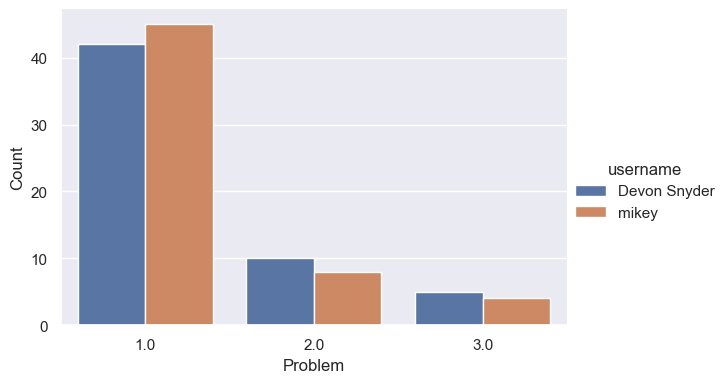

In [21]:
plot_severity(chicago,2)

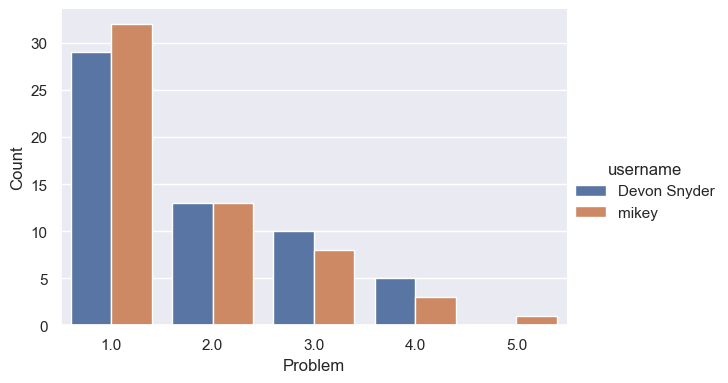

In [23]:
plot_severity_5(chicago,2)

In [22]:
t_test(chicago,2)

Ttest_indResult(statistic=-0.6082287370157644, pvalue=0.5442672590901898)

In [14]:
def agree_rate(label_data,i):
    df = cluster_label_type_at_index(label_data,i)[2]
    df["clustered"] = df.duplicated(subset="cluster", keep=False)
    df1 = df[df['clustered'] == True]
    
    if len(df) == 0:
        return 0
    else: 
        return len(df1)/len(df)

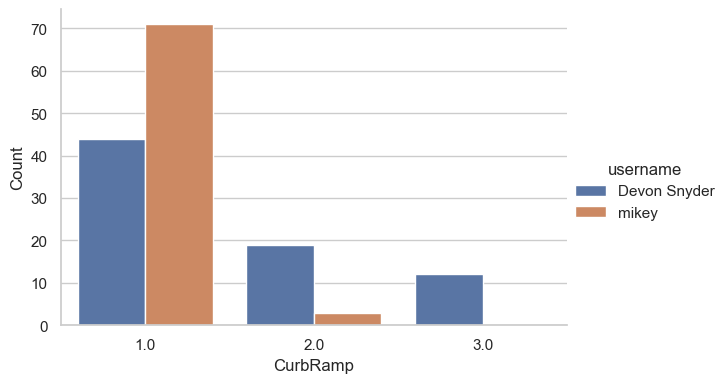

In [93]:
plot_severity(seattle,0)

In [94]:
t_test(seattle,0)

Ttest_indResult(statistic=-0.9999999999999998, pvalue=0.3205693108560599)

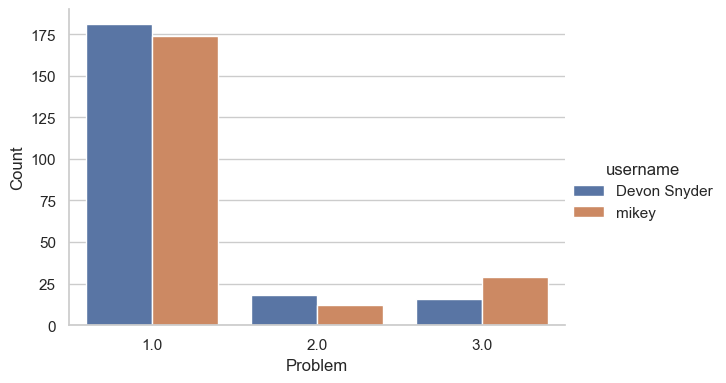

In [95]:
plot_severity(seattle,2)

In [97]:
t_test(seattle,2)

Ttest_indResult(statistic=1.5058385268262229, pvalue=0.1328462724006202)

With a p-value of more than 0.05, fail to reject the null hypothesis of the two ratings mean being equal.

# Mapping

In [181]:
visualize_validation(street_s,2)

In [31]:
visualize_validation(street_c,2)

In [37]:
visualize_validation(seattle,0)

In [38]:
visualize_validation(seattle,2)

In [32]:
visualize_validation(seattle,1)

In [33]:
visualize_validation(seattle,7)

In [34]:
visualize_validation(chicago,0)

In [35]:
visualize_validation(chicago,1)

In [36]:
visualize_validation(chicago,2)

In [24]:
j=[]
k=[]
l=[]
for i in [0,2,7,1]:
     j.append(agree_rate(seattle,i))
for i in [0,2,7,1]:
    k.append(agree_rate(chicago,i))
for i in [0,2,7,1]:
    l.append( label_types[i])

In [25]:
agree_rate_df = pd.DataFrame(list(zip(l,j, k)),
              columns=['label_type','seattle', 'chicago'])

In [26]:
#Save to excel
writer = pd.ExcelWriter('agreement_rate_221011.xlsx', engine='xlsxwriter')
agree_rate.to_excel(writer, sheet_name='Agreement Rate')
writer.save()

ModuleNotFoundError: No module named 'xlsxwriter'

In [27]:
agree_rate_df.round(2)

,label_type,seattle,chicago
0,CurbRamp,0.76,0.68
1,Problem,0.51,0.37
2,NoCurbRamp,0.84,0.00
3,NoSidewalk,0.66,0.55
